In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os, sys
sys.path.append(os.path.join('..','..','libs'))
from read_smn import read_smn

# RNN en predicciones

Vamos a ver cómo utilizar RNNs para predecir datos futuros. En este caso utilizaremos los datos del SMN para poder comparar con lo estudiado de MLP

## Problema univariado

In [3]:
# leemos los datos
readr = read_smn(os.path.join('..','..','Data','junio-SMN','horario'))

In [4]:
# Utilizamos sólo SALTA
tstamps, data = readr.filter_by_station('SALTA')
data = data[:,0]  # solo la temperatura
train = data[:600] # split train y test
test = data[600:]

In [4]:
from sklearn.preprocessing import MinMaxScaler
class DataPipeline:
    def __init__(self, train_data, lookback) -> None:
        self.train_data = train_data.reshape(-1,1)
        self.scaler = MinMaxScaler()
        self.train_data = self.scaler.fit_transform(self.train_data)
        self.lookback = lookback
        self.train_x, self.train_y = self.split_series(self.train_data)

    def transform(self, data):
        '''wrapper to transform new data'''
        return self.scaler.transform(data)
    
    def inverse_transform(self, data):
        '''wraper to inverse transform'''
        return self.scaler.inverse_transform(data)
    
    def split_series(self, data):
        ''' tenemos una unica serie, entonces la partimos en lookback pedacitos
            para crear muchas series cortas de longitud lookback
        '''
        x = []
        y = []
        for i in range(self.train_data.shape[0]-self.lookback):
            x.append(self.train_data[i:i+self.lookback]) # creamos directamente los arrays con la forma que queremos
            y.append(self.train_data[i+self.lookback])
        return np.array(x), np.array(y)

    def perform_transformations(self, data):
        '''
        This method perform transformations for any single valued series
        series length must be larger than lookback
        '''
        assert len(data) > self.lookback
        data = self.transform(data)
        x, y = self.split_series(data)
        return x, y

In [5]:
# Usamos un dataset y dataloader para hacer todo mas simple con pytorch
# como las series ya traen la forma que necesitamos, 
# solo hay que hacer un cast de numpy a pytorch

class DataSet(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.X = x
        self.Y = y
        self.X = torch.from_numpy(self.X).float()
        self.Y = torch.from_numpy(self.Y).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [6]:
# vamos a crear un objeto para preprocesar los datos
lookback = 12

pipe = DataPipeline(train_data= train, lookback= lookback)

# creamos los datasets y dataloaders en un diccionario para manejar mas simple

dataset = DataSet(pipe.train_x, pipe.train_y)

dataloader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle= True)

print(f'Tenemos {len(dataset)} series temporales de largo {lookback}')

Tenemos 588 series temporales de largo 12


In [7]:
# Definimos la rnn mas pequeña posible
class RNN(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.rnn  = torch.nn.RNN(
                                input_size  = 1,    # la serie es univariada y entra una sola feature
                                hidden_size = 1,
                                num_layers  = 1,
                                batch_first = True
                                )
    
    def forward(self, x):
        x, h = self.rnn(x)
        return x, h     # retornamos todos los valores

rnn = RNN()
print(rnn)

RNN(
  (rnn): RNN(1, 1, batch_first=True)
)


In [8]:
print('parametros de la rnn')
print('-'*50)
print(f'weights: input-hidden -layer:0 = {rnn.rnn.weight_ih_l0}')
print(f'weights: hidden-hidden -layer:0 = {rnn.rnn.weight_hh_l0}')
print(f'bias: input-hidden -layer:0 = {rnn.rnn.bias_ih_l0}')
print(f'bias: hidden-hidden -layer:0 = {rnn.rnn.bias_hh_l0}')

parametros de la rnn
--------------------------------------------------
weights: input-hidden -layer:0 = Parameter containing:
tensor([[0.8583]], requires_grad=True)
weights: hidden-hidden -layer:0 = Parameter containing:
tensor([[0.2448]], requires_grad=True)
bias: input-hidden -layer:0 = Parameter containing:
tensor([-0.8259], requires_grad=True)
bias: hidden-hidden -layer:0 = Parameter containing:
tensor([-0.9240], requires_grad=True)


In [9]:
# veamos como se comporta nuestra red super simple
x = np.ones(shape=(1,lookback,1))   # hacemos un vector de unos
x = torch.from_numpy(x).float()     # lo pasamos a 
y, h = rnn(x)
print('forward del modelo:') # una salida por cada paso temporal
print(y)
print('Estado de las capas ocultas al final:') # el estado de las capas ocultas al final de la serie
print(h)

forward del modelo:
tensor([[[-0.7122],
         [-0.7879],
         [-0.7949],
         [-0.7955],
         [-0.7956],
         [-0.7956],
         [-0.7956],
         [-0.7956],
         [-0.7956],
         [-0.7956],
         [-0.7956],
         [-0.7956]]], grad_fn=<TransposeBackward1>)
Estado de las capas ocultas al final:
tensor([[[-0.7956]]], grad_fn=<StackBackward0>)


In [9]:
def fit(model, dataloader, epochs = 10, eval = False):
    '''
    Funcion para entrenar el modelo model utilizando un dataloader
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
    criterion = torch.nn.MSELoss()
    history = []
    for epoch in range(1,epochs+1):
        model.train()   # ponemos el modelo para ser entrenado
        train_h = [] 
        
        # leer los datos en el dataloader es muy simple (recorrer por batches)! 
        for x_b, y_b in dataloader['train']:

            # ponemos los gradientes a cero
            optimizer.zero_grad()
            
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)

            # calculamos los gradientes
            loss.backward()
            
            # actualizamos todos los pesos
            optimizer.step()
            train_h.append(loss.item())

        if eval:
            model.eval() # no estamos entrenando
            test_h = [] 
            with torch.no_grad():  # no vamos a hacer backward, solo ver la metrica sobre el test
                for x_b, y_b in dataloader['valid']:
                    y_pred = model(x_b)
                    loss = criterion(y_pred, y_b)
                    test_h.append(loss.item())
        if (epoch%50 == 0):
            if eval:
                print(f'epoch: {epoch}/{epochs} - train loss: {np.mean(train_h):.3f} - valid loss: {np.mean(test_h):.3f}')
                history.append([np.mean(train_h), np.mean(test_h)])
            else:
                print(f'epoch: {epoch}/{epochs} - train loss: {np.mean(train_h):.3f}')
                history.append([np.mean(train_h)])
    return history


In [11]:
# creamos un modelo que devuelva solo el ultimo valor (MANY TO ONE)
class RNN(torch.nn.Module):
    def __init__(self, hs = 1, nl = 1 ) -> None:
        super().__init__()

        self.rnn  = torch.nn.RNN(
                                input_size  = 1,    # la serie es univariada y entra una sola feature
                                hidden_size = hs,
                                num_layers  = nl,
                                batch_first = True
                                )
        self.drop = torch.nn.Dropout(0.3)
        self.lin = torch.nn.Linear(hs,1)
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.drop(x)
        x = self.lin(x[:,-1])
        return x     # retornamos el último valor

epoch: 50/100 - train loss: 0.032
epoch: 100/100 - train loss: 0.018


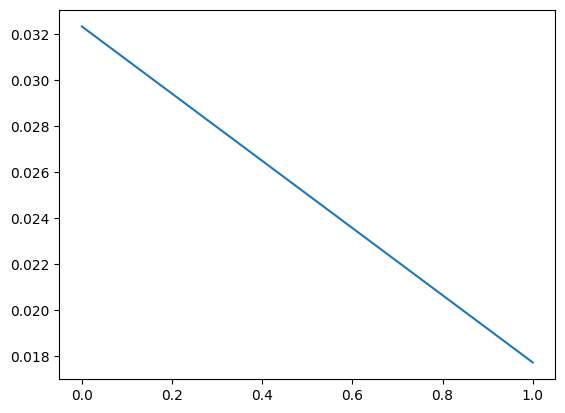

In [12]:
rnn = RNN()
his = fit(rnn,{'train': dataloader},epochs=100)
plt.plot(his)

Vamos a utilizar el conjunto que reservamos como test para evaluar el error y ver las predicciones

(588, 1)


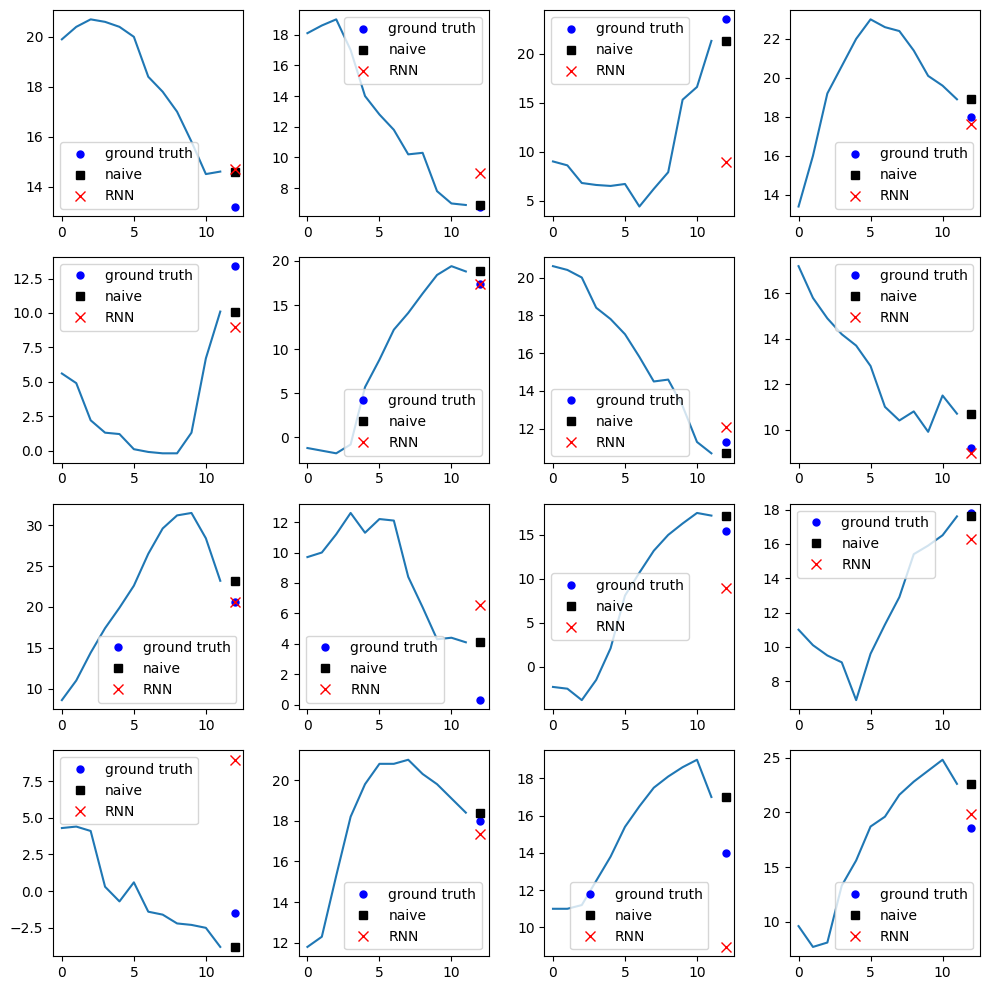

In [13]:
from sklearn.metrics import mean_absolute_error, explained_variance_score
sys.path.append(os.path.join('..','..'))
from libs import prediction_models

# Transformamos para poder predecir con el modelo
testx, testy = pipe.perform_transformations(test.reshape(-1,1))
predicted = rnn(torch.from_numpy(testx).float()).detach().numpy()

# aplicamos la transformacion inversa a todo lo que predecimos
predicted = pipe.inverse_transform(predicted)
# idem los datos
print(testy.shape)
testx = pipe.inverse_transform(testx.reshape(-1,1)).reshape(588,-1)
testy = pipe.inverse_transform(testy)

fig, axs = plt.subplots(4,4,figsize = (10,10))
for i in range(4):
    for j in range(4):
        # plot some random samples from test
        idx = np.random.randint(0,predicted.shape[0])
        axs[i,j].plot(testx[idx,:])
        axs[i,j].plot(lookback,testy[idx,:], 'bo', ms = 5, label = 'ground truth')
        axs[i,j].plot(lookback, prediction_models.naive(testx[idx,:]), 'ks', label = 'naive')
        axs[i,j].plot(lookback, predicted[idx], 'rx', ms = 7, label = 'RNN')
        axs[i,j].legend()
fig.tight_layout()

In [14]:
def perform_multiple_models(train_data, lookback = 1, rnn_hs = 1, rnn_nl = 1):
    pipe = DataPipeline(train_data= train_data, lookback= lookback)
    # creamos los datasets y dataloaders en un diccionario para manejar mas simple
    dataset = DataSet(pipe.train_x, pipe.train_y)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle= True)
    rnn = RNN(hs= rnn_hs, nl= rnn_nl)
    his = fit(rnn,{'train': dataloader},epochs=150)
    return pipe, rnn

def evaluate_test_on_model(test_data, pipe, rnn):
    rnn.eval()
    # Transformamos para poder predecir con el modelo
    testx, testy = pipe.perform_transformations(test_data.reshape(-1,1))
    predicted = rnn(torch.from_numpy(testx).float()).detach().numpy()

    # aplicamos la transformacion inversa a todo lo que predecimos
    predicted = pipe.inverse_transform(predicted)
    # idem los ground truth
    testy = pipe.inverse_transform(testy)
    testx = pipe.inverse_transform(testx[:,:,0])
    print(testx.shape)
    metrics = {
        'mae_mod': mean_absolute_error(predicted, testy),
        'r2_mod': explained_variance_score(predicted, testy),
        'mae_naive': mean_absolute_error(prediction_models.naive(testx[:,:]),testy),
        'r2_naive': explained_variance_score(prediction_models.naive(testx[:,:]),testy)
    }
    return  metrics


In [15]:
model_metrics = {}
for l in [1,3,12,24]:
    for hidden_size in [1,2,4,8,16,32]:
        for num_layers in [1,2]:
            print(l, hidden_size, num_layers)
            pipe, model = perform_multiple_models(train, lookback= l, rnn_hs= hidden_size, rnn_nl= num_layers)
            total_params = sum(p.numel() for p in model.parameters())
            metrics = evaluate_test_on_model(test, pipe, model)
            model_metrics[(l, hidden_size, num_layers)] = {
                'param_num': total_params,
                'metrics': metrics
            }

1 1 1
epoch: 50/150 - train loss: 0.016
epoch: 100/150 - train loss: 0.011
epoch: 150/150 - train loss: 0.012
(599, 1)
1 1 2
epoch: 50/150 - train loss: 0.085
epoch: 100/150 - train loss: 0.021
epoch: 150/150 - train loss: 0.013
(599, 1)
1 2 1
epoch: 50/150 - train loss: 0.026
epoch: 100/150 - train loss: 0.012
epoch: 150/150 - train loss: 0.014
(599, 1)
1 2 2
epoch: 50/150 - train loss: 0.076
epoch: 100/150 - train loss: 0.041
epoch: 150/150 - train loss: 0.021
(599, 1)
1 4 1
epoch: 50/150 - train loss: 0.070
epoch: 100/150 - train loss: 0.039
epoch: 150/150 - train loss: 0.026
(599, 1)
1 4 2
epoch: 50/150 - train loss: 0.035
epoch: 100/150 - train loss: 0.010
epoch: 150/150 - train loss: 0.007
(599, 1)
1 8 1
epoch: 50/150 - train loss: 0.045
epoch: 100/150 - train loss: 0.029
epoch: 150/150 - train loss: 0.015
(599, 1)
1 8 2
epoch: 50/150 - train loss: 0.005
epoch: 100/150 - train loss: 0.004
epoch: 150/150 - train loss: 0.005
(599, 1)
1 16 1
epoch: 50/150 - train loss: 0.012
epoch: 

In [16]:
print(f'lookback - hidden size - num hidden layers\t| Num params\t| RNN MAE\t| Naive MAE\t|')
print(f'-'*100)
for k in model_metrics.keys():
    print(f'''{k[0]} \t- \t{k[1]} \t- \t{k[2]}\t\t| {model_metrics[k]["param_num"]}\t\t| \
{model_metrics[k]["metrics"]["mae_mod"]:.4f}\t| {model_metrics[k]["metrics"]["mae_naive"]:.4f}''')
    

lookback - hidden size - num hidden layers	| Num params	| RNN MAE	| Naive MAE	|
----------------------------------------------------------------------------------------------------
1 	- 	1 	- 	1		| 6		| 2.1117	| 1.3003
1 	- 	1 	- 	2		| 10		| 2.1731	| 1.3003
1 	- 	2 	- 	1		| 13		| 2.0410	| 1.3003
1 	- 	2 	- 	2		| 25		| 3.1610	| 1.3003
1 	- 	4 	- 	1		| 33		| 2.8111	| 1.3003
1 	- 	4 	- 	2		| 73		| 1.4735	| 1.3003
1 	- 	8 	- 	1		| 97		| 1.7623	| 1.3003
1 	- 	8 	- 	2		| 241		| 1.4454	| 1.3003
1 	- 	16 	- 	1		| 321		| 1.3959	| 1.3003
1 	- 	16 	- 	2		| 865		| 1.3528	| 1.3003
1 	- 	32 	- 	1		| 1153		| 1.3294	| 1.3003
1 	- 	32 	- 	2		| 3265		| 1.3890	| 1.3003
3 	- 	1 	- 	1		| 6		| 2.2859	| 1.3007
3 	- 	1 	- 	2		| 10		| 4.1978	| 1.3007
3 	- 	2 	- 	1		| 13		| 2.1831	| 1.3007
3 	- 	2 	- 	2		| 25		| 4.7554	| 1.3007
3 	- 	4 	- 	1		| 33		| 1.3948	| 1.3007
3 	- 	4 	- 	2		| 73		| 1.4924	| 1.3007
3 	- 	8 	- 	1		| 97		| 1.2495	| 1.3007
3 	- 	8 	- 	2		| 241		| 1.0498	| 1.3007
3 	- 	16 	- 	1		| 321		| 1.34

# Implementando LSTMs

In [21]:
# creamos un modelo que devuelva solo el ultimo valor (MANY TO ONE)
class LSTM(torch.nn.Module):
    def __init__(self, hs = 1, nl = 1 ) -> None:
        super().__init__()

        self.rnn  = torch.nn.LSTM(
                                input_size  = 1,    # la serie es univariada y entra una sola feature
                                hidden_size = hs,
                                num_layers  = nl,
                                batch_first = True
                                )
        self.drop = torch.nn.Dropout(0.3)
        self.lin = torch.nn.Linear(hs,1)
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.drop(x)
        x = self.lin(x[:,-1])
        return x     # retornamos el último valor

In [22]:
def perform_multiple_models(train_data, lookback = 1, rnn_hs = 1, rnn_nl = 1):
    pipe = DataPipeline(train_data= train_data, lookback= lookback)
    # creamos los datasets y dataloaders en un diccionario para manejar mas simple
    dataset = DataSet(pipe.train_x, pipe.train_y)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle= True)
    rnn = LSTM(hs= rnn_hs, nl= rnn_nl)
    his = fit(rnn,{'train': dataloader},epochs=150)
    return pipe, rnn

def evaluate_test_on_model(test_data, pipe, rnn):
    rnn.eval()
    # Transformamos para poder predecir con el modelo
    testx, testy = pipe.perform_transformations(test_data.reshape(-1,1))
    predicted = rnn(torch.from_numpy(testx).float()).detach().numpy()

    # aplicamos la transformacion inversa a todo lo que predecimos
    predicted = pipe.inverse_transform(predicted)
    # idem los ground truth
    testy = pipe.inverse_transform(testy)
    testx = pipe.inverse_transform(testx[:,:,0])
    print(testx.shape)
    metrics = {
        'mae_mod': mean_absolute_error(predicted, testy),
        'r2_mod': explained_variance_score(predicted, testy),
        'mae_naive': mean_absolute_error(prediction_models.naive(testx[:,:]),testy),
        'r2_naive': explained_variance_score(prediction_models.naive(testx[:,:]),testy)
    }
    return  metrics


In [23]:
model_metrics = {}
for l in [1,3,12,24]:
    for hidden_size in [1,2,4,8,16,32]:
        for num_layers in [1,2]:
            print(l, hidden_size, num_layers)
            pipe, model = perform_multiple_models(train, lookback= l, rnn_hs= hidden_size, rnn_nl= num_layers)
            total_params = sum(p.numel() for p in model.parameters())
            metrics = evaluate_test_on_model(test, pipe, model)
            model_metrics[(l, hidden_size, num_layers)] = {
                'param_num': total_params,
                'metrics': metrics
            }

1 1 1
epoch: 50/150 - train loss: 0.066
epoch: 100/150 - train loss: 0.051
epoch: 150/150 - train loss: 0.040
(599, 1)
1 1 2
epoch: 50/150 - train loss: 0.742
epoch: 100/150 - train loss: 0.192
epoch: 150/150 - train loss: 0.115
(599, 1)
1 2 1
epoch: 50/150 - train loss: 0.036
epoch: 100/150 - train loss: 0.029
epoch: 150/150 - train loss: 0.012
(599, 1)
1 2 2
epoch: 50/150 - train loss: 0.036
epoch: 100/150 - train loss: 0.027
epoch: 150/150 - train loss: 0.013
(599, 1)
1 4 1
epoch: 50/150 - train loss: 0.055
epoch: 100/150 - train loss: 0.043
epoch: 150/150 - train loss: 0.021
(599, 1)
1 4 2
epoch: 50/150 - train loss: 0.063
epoch: 100/150 - train loss: 0.038
epoch: 150/150 - train loss: 0.019
(599, 1)
1 8 1
epoch: 50/150 - train loss: 0.022
epoch: 100/150 - train loss: 0.010
epoch: 150/150 - train loss: 0.007
(599, 1)
1 8 2
epoch: 50/150 - train loss: 0.006
epoch: 100/150 - train loss: 0.005
epoch: 150/150 - train loss: 0.004
(599, 1)
1 16 1
epoch: 50/150 - train loss: 0.014
epoch: 

In [24]:
print(f'lookback - hidden size - num hidden layers\t| Num params\t| RNN MAE\t| Naive MAE\t|')
print(f'-'*100)
for k in model_metrics.keys():
    print(f'''{k[0]} \t- \t{k[1]} \t- \t{k[2]}\t\t| {model_metrics[k]["param_num"]}\t\t| \
{model_metrics[k]["metrics"]["mae_mod"]:.4f}\t| {model_metrics[k]["metrics"]["mae_naive"]:.4f}''')

lookback - hidden size - num hidden layers	| Num params	| RNN MAE	| Naive MAE	|
----------------------------------------------------------------------------------------------------
1 	- 	1 	- 	1		| 18		| 5.2460	| 1.3003
1 	- 	1 	- 	2		| 34		| 6.7071	| 1.3003
1 	- 	2 	- 	1		| 43		| 2.0919	| 1.3003
1 	- 	2 	- 	2		| 91		| 2.1126	| 1.3003
1 	- 	4 	- 	1		| 117		| 2.6803	| 1.3003
1 	- 	4 	- 	2		| 277		| 2.1024	| 1.3003
1 	- 	8 	- 	1		| 361		| 1.4521	| 1.3003
1 	- 	8 	- 	2		| 937		| 1.3793	| 1.3003
1 	- 	16 	- 	1		| 1233		| 1.4373	| 1.3003
1 	- 	16 	- 	2		| 3409		| 1.3699	| 1.3003
1 	- 	32 	- 	1		| 4513		| 1.3935	| 1.3003
1 	- 	32 	- 	2		| 12961		| 1.3771	| 1.3003
3 	- 	1 	- 	1		| 18		| 4.7090	| 1.3007
3 	- 	1 	- 	2		| 34		| 5.4355	| 1.3007
3 	- 	2 	- 	1		| 43		| 2.6145	| 1.3007
3 	- 	2 	- 	2		| 91		| 3.1275	| 1.3007
3 	- 	4 	- 	1		| 117		| 2.1772	| 1.3007
3 	- 	4 	- 	2		| 277		| 2.0081	| 1.3007
3 	- 	8 	- 	1		| 361		| 1.5495	| 1.3007
3 	- 	8 	- 	2		| 937		| 2.4596	| 1.3007
3 	- 	16 	- 	1		| 

# El Problema UNO a MUCHOS (one to many)

Supongamos que queremos predecir medio día de temperaturas

In [48]:
from sklearn.preprocessing import MinMaxScaler
class DataPipeline:
    def __init__(self, train_data, lookback, horizon) -> None:
        self.train_data = train_data.reshape(-1,1)
        self.scaler = MinMaxScaler()
        self.train_data = self.scaler.fit_transform(self.train_data)
        self.lookback = lookback
        self.horizon = horizon
        self.train_x, self.train_y = self.split_series(self.train_data)

    def transform(self, data):
        '''wrapper to transform new data'''
        return self.scaler.transform(data)
    
    def inverse_transform(self, data):
        '''wraper to inverse transform'''
        return self.scaler.inverse_transform(data)
    
    def split_series(self, data):
        ''' tenemos una unica serie, entonces la partimos en lookback pedacitos
            para crear muchas series cortas de longitud lookback
        '''
        x = []
        y = []
        for i in range(self.train_data.shape[0]-self.lookback - self.horizon):
            x.append(self.train_data[i:i+self.lookback]) # creamos directamente los arrays con la forma que queremos
            idx_aux = i+self.lookback
            y.append(self.train_data[idx_aux:idx_aux+self.horizon])
        return np.array(x), np.array(y)

    def perform_transformations(self, data):
        '''
        This method perform transformations for any single valued series
        series length must be larger than lookback
        '''
        assert len(data) > self.lookback
        data = self.transform(data)
        x, y = self.split_series(data)
        return x, y

In [49]:
lookback = 24
horizon = 6
pipe = DataPipeline(train, lookback=lookback, horizon=horizon)
print(f'Las dimensiones de x: {pipe.train_x.shape} - y: {pipe.train_y.shape}')

Las dimensiones de x: (570, 24, 1) - y: (570, 6, 1)


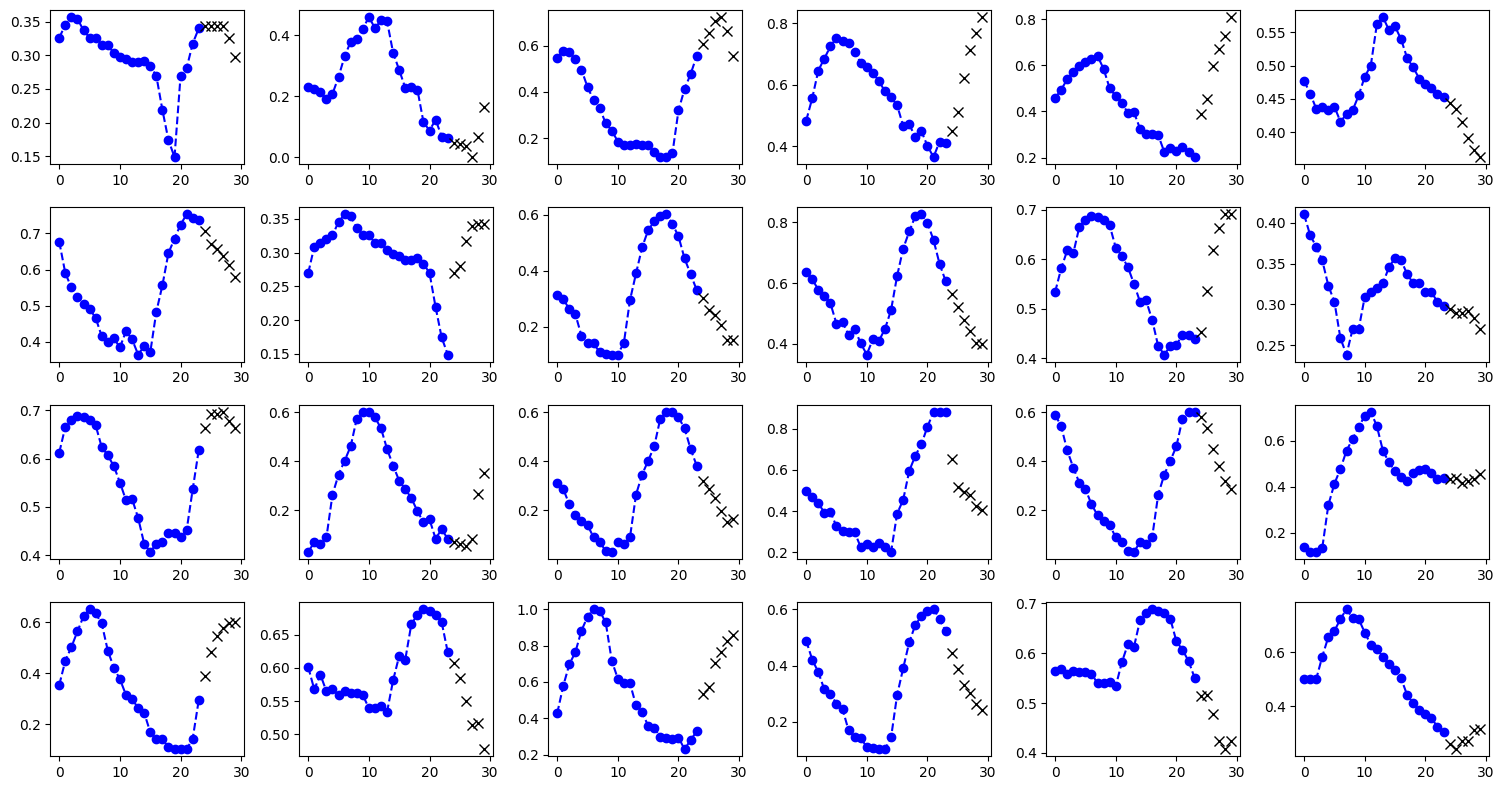

In [50]:
fig, axs = plt.subplots(4,6, figsize = (15,8))
for i in range(4):
    for j in range(6):
        idx = np.random.randint(0, pipe.train_x.shape[0])
        axs[i,j].plot(np.arange(24),pipe.train_x[idx].reshape(-1), 'bo--', label = 'X')
        axs[i,j].plot(np.arange(24,30), pipe.train_y[idx].reshape(-1), 'kx', ms = 7, label = 'Y')
fig.tight_layout()

In [85]:
# creamos un modelo que devuelva solo el ultimo valor (MANY TO ONE)
class RNN(torch.nn.Module):
    def __init__(self, hs = 1, nl = 1, no = 1 ) -> None:
        super().__init__()

        self.rnn  = torch.nn.RNN(
                                input_size  = 1,    # la serie es univariada y entra una sola feature
                                hidden_size = hs,
                                num_layers  = nl,
                                batch_first = True
                                )
        self.drop = torch.nn.Dropout(0.3)
        self.lin = torch.nn.Linear(hs,no)  # no es el numero de outputs
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.drop(x)
        x = self.lin(x[:,-1])
        return x     # retornamos el último valor

In [86]:
# Usamos un dataset y dataloader para hacer todo mas simple con pytorch
# como las series ya traen la forma que necesitamos, 
# solo hay que hacer un cast de numpy a pytorch

class DataSet(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.X = x
        self.Y = y
        self.X = torch.from_numpy(self.X).float()
        self.Y = torch.from_numpy(self.Y).float().view(-1,y.shape[1])

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [87]:
def fit(model, dataloader, epochs = 10, eval = False):
    '''
    Funcion para entrenar el modelo model utilizando un dataloader
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
    criterion = torch.nn.MSELoss()
    history = []
    for epoch in range(1,epochs+1):
        model.train()   # ponemos el modelo para ser entrenado
        train_h = [] 
        
        # leer los datos en el dataloader es muy simple (recorrer por batches)! 
        for x_b, y_b in dataloader['train']:

            # ponemos los gradientes a cero
            optimizer.zero_grad()
            
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)

            # calculamos los gradientes
            loss.backward()
            
            # actualizamos todos los pesos
            optimizer.step()
            train_h.append(loss.item())

        if eval:
            model.eval() # no estamos entrenando
            test_h = [] 
            with torch.no_grad():  # no vamos a hacer backward, solo ver la metrica sobre el test
                for x_b, y_b in dataloader['valid']:
                    y_pred = model(x_b)
                    loss = criterion(y_pred, y_b)
                    test_h.append(loss.item())
        if (epoch%50 == 0):
            if eval:
                print(f'epoch: {epoch}/{epochs} - train loss: {np.mean(train_h):.3f} - valid loss: {np.mean(test_h):.3f}')
                history.append([np.mean(train_h), np.mean(test_h)])
            else:
                print(f'epoch: {epoch}/{epochs} - train loss: {np.mean(train_h):.3f}')
                history.append([np.mean(train_h)])
    return history

In [88]:
# creamos los datasets y dataloaders en un diccionario para manejar mas simple
dataset = DataSet(pipe.train_x, pipe.train_y)

dataloader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle= True)
rnn = RNN(hs= 32, nl= 2, no=horizon)
his = fit(rnn,{'train': dataloader},epochs=150)

epoch: 50/150 - train loss: 0.018
epoch: 100/150 - train loss: 0.010
epoch: 150/150 - train loss: 0.008


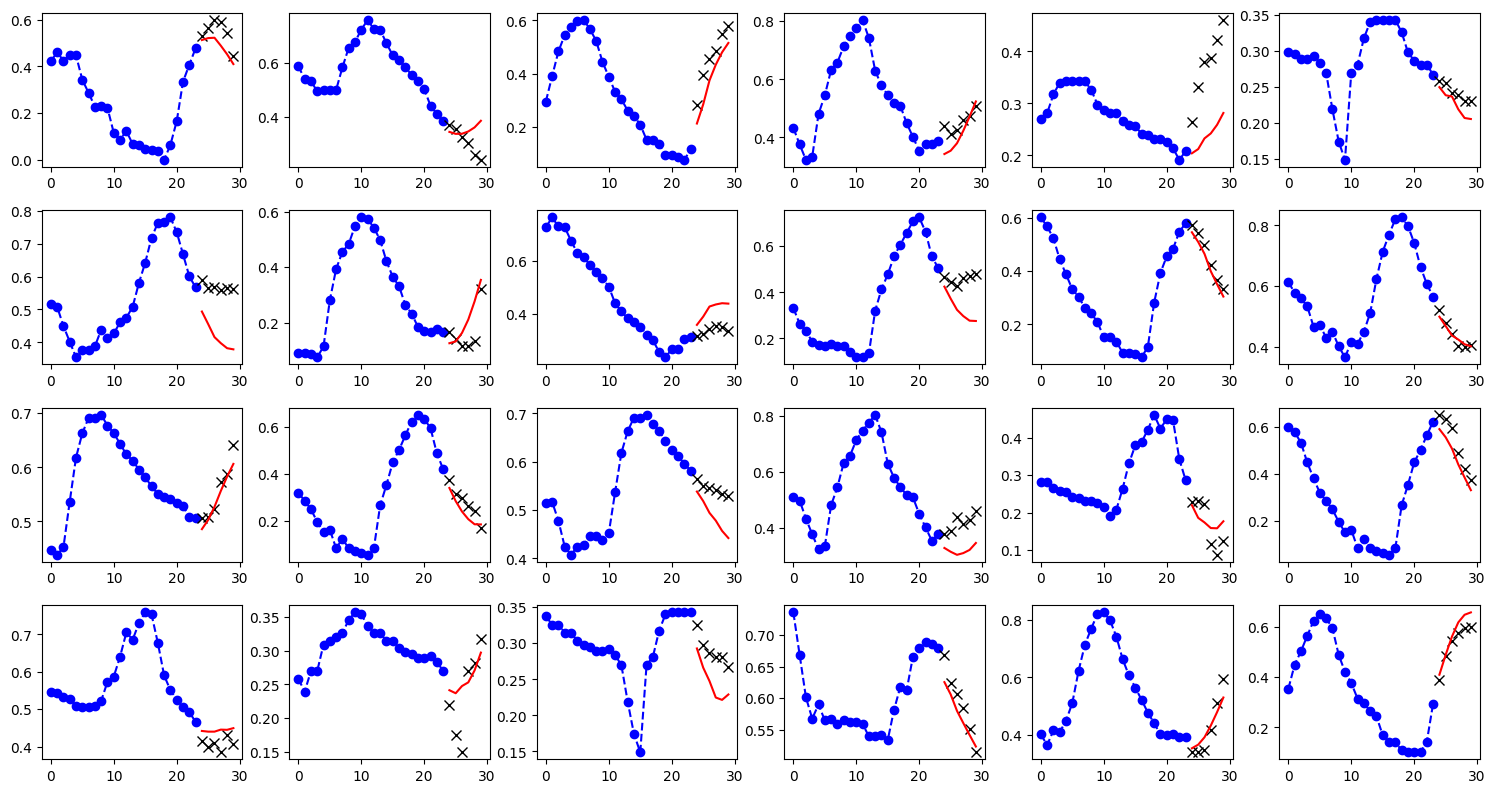

In [89]:
fig, axs = plt.subplots(4,6, figsize = (15,8))
rnn.eval()
for i in range(4):
    for j in range(6):
        idx = np.random.randint(0, pipe.train_x.shape[0])
        axs[i,j].plot(np.arange(lookback),pipe.train_x[idx].reshape(-1), 'bo--', label = 'X')
        axs[i,j].plot(np.arange(lookback,lookback+horizon), pipe.train_y[idx].reshape(-1), 'kx', ms = 7, label = 'Y')
        pred = rnn(torch.from_numpy(pipe.train_x[idx].reshape(1,lookback,1)).float())
        axs[i,j].plot(np.arange(lookback,lookback+horizon),pred.detach().numpy().reshape(-1), 'r-', label = 'predicted')
fig.tight_layout()